In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

In [2]:
class RateEncoder:
    """Rate encoder to convert real-valued inputs to spike trains"""
    
    def __init__(self, num_steps=200, max_rate=100, min_rate=0, dt=1e-3):
        self.num_steps = num_steps
        self.max_rate = max_rate
        self.min_rate = min_rate
        self.dt = dt
    
    def encode(self, data):
        """
        Encode real-valued data into spike trains using rate encoding
        
        Args:
            data: Tensor of shape (batch_size, input_features)
        
        Returns:
            spikes: Tensor of shape (num_steps, batch_size, input_features)
        """
        batch_size, input_features = data.shape
        
        # Normalize data to [0, 1] range
        data_min = torch.min(data, dim=1, keepdim=True)[0]
        data_max = torch.max(data, dim=1, keepdim=True)[0]
        data_range = data_max - data_min
        
        # Handle case where all values are the same
        data_range = torch.where(data_range == 0, torch.ones_like(data_range), data_range)
        data_norm = (data - data_min) / data_range
        
        # Convert to firing rates
        rates = self.min_rate + (self.max_rate - self.min_rate) * data_norm
        
        # Generate Poisson spike trains
        spike_prob = rates * self.dt
        spike_prob = torch.clamp(spike_prob, 0, 1)  # Ensure probability is valid
        
        # Generate spikes for all time steps
        spikes = torch.rand(self.num_steps, batch_size, input_features) < spike_prob.unsqueeze(0)
        
        return spikes.float()

In [3]:
class RateDecoder:
    """Rate decoder to convert spike trains back to real-valued outputs"""
    
    def __init__(self, num_steps, output_range=(0, 1)):
        self.num_steps = num_steps
        self.output_min, self.output_max = output_range
    
    def decode(self, spike_trains):
        """
        Decode spike trains to real-valued outputs using spike rate
        
        Args:
            spike_trains: Tensor of shape (num_steps, batch_size, output_features)
        
        Returns:
            outputs: Tensor of shape (batch_size, output_features)
        """
        # Calculate spike rates (spikes per time step)
        spike_rates = torch.mean(spike_trains, dim=0)  # Average over time steps
        
        # Convert spike rates to output range
        outputs = self.output_min + (self.output_max - self.output_min) * spike_rates
        
        return outputs

In [4]:
class SNNRegressor(nn.Module):
    """
    SNN Network for regression implementing the architecture from Figure 2
    """
    
    def __init__(self, net_params):
        super(SNNRegressor, self).__init__()

        self.net_params = net_params
        
        num_steps = self.net_params['num_steps']
        input_dim = self.net_params['input_dim']
        output_dim = self.net_params['output_dim']
        output_range = self.net_params['output_range']
        
        Conv_layers_RELU = self.net_params['Conv_layers_RELU']
        Conv_layers = self.net_params['Conv_layers']
        input_dim = self.net_params['input_dim']
        FC_layers = self.net_params['FC_layers']
        
        # Rate encoder and decoder
        self.encoder = RateEncoder(num_steps=num_steps)
        self.decoder = RateDecoder(num_steps=num_steps, output_range=output_range)
        
        # Network layers following the architecture
        # Layer 1: Fully Connected + ReLU (Red neurons)
        self.fc1 = nn.Linear(input_dim, FC_layers[0])
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        
        # Layer 2: Fully Connected + ReLU (Red neurons) 
        self.fc2 = nn.Linear(FC_layers[0], FC_layers[1])
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        
        # Layer 3: Fully Connected + ReLU (Red neurons)
        self.fc3 = nn.Linear(FC_layers[1], FC_layers[2])
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        
        # Layer 4: Convolutional + ReLU (Blue neurons)
        # For simplicity, we'll use 1D conv or treat as fully connected
        self.conv1 = nn.Conv2d(Conv_layers_RELU[0], Conv_layers_RELU[1], Conv_layers_RELU[2])
        self.lif4 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        
        # Layer 5: Convolutional (Yellow neurons)
        self.conv2 = nn.Conv2d(Conv_layers[0], Conv_layers[1], Conv_layers[2])
        
        # Layer 6: Output layer (Green neurons) - Customized for regression
        self.fc_A = nn.Linear(self.net_params['dim_layer_a'], 1, bias = False)

        # Average pooling (works better than max pooling for SNNs)
        self.max_pool1 = nn.MaxPool2d(Conv_layers_RELU[2][0])
        self.max_pool2 = nn.MaxPool2d(Conv_layers[2][0])

        
    def forward(self, x):
        """
        Forward pass through the network
        
        Args:
            x: Input tensor of shape (batch_size, input_size)
            
        Returns:
            outputs: Decoded real-valued outputs of shape (batch_size, output_size)
            spk_rec: Output spike recordings (for visualization)
            mem_rec: Output membrane potential recordings (for visualization)
        """
        m = self.net_params['output_dim']
        n = self.net_params['num_joints']
        batch_size = x.size(0)
        
        # Encode input to spikes
        spk_in = self.encoder.encode(x[:2*n,:])
        
        
        # Initialize hidden states for all layers
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()

        
        # Record spikes and membrane potentials
        spk_rec = []
        mem_rec = []
        
        # Process each time step
        for step in range(self.num_steps):
            # Layer 1
            cur1 = self.fc1(spk_in[step])
            spk1, mem1 = self.lif1(cur1, mem1)
            
            # Layer 2  
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            
            # Layer 3
            cur3 = self.fc3(spk2)
            spk3, mem3 = self.lif3(cur3, mem3)
            
            # Layer 4
            spk_conv = torch.cat((self.encoder.encode(x[:,n:2*n].unsqueeze(1)), spk3.unsqueeze(1), self.encoder.encode(x[:,2*n:].unsqueeze(1))), 1)
            
            cur4 = self.conv1(spk_conv)
            spk4, mem4 = self.lif4(self.maxpool1(cur4), mem4)
            
            # Layer 5
            conv_out = self.maxpool2(self.conv2(spk4))
            # cur5 = self.pool(cur5)
            
            conv_flat = conv_out.view(batch_size, -1)
            
            # Output layer
            output = self.fc6(conv_flat)
            
            out_a = self.fc_A(out2[:,:,0,:].squeeze()).squeeze()
            out_b = self.fc_A(out2[:,:,1,:].squeeze()).squeeze()
            out_c = self.fc_A(out2[:,:,2,:].squeeze()).squeeze()
    
            if m==3:
                c = torch.vstack((out_a,out_b,out_c))
            elif m==2:
                c = torch.vstack((out_a,out_b))
    
            if Train:
                return c.T
            else:
                return c.T.detach().numpy()
        

In [5]:


def train_snn_regressor(model, train_loader, test_loader, num_epochs=10, lr=1e-3):
    """
    Train the SNN regressor using MSE loss
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Loss function and optimizer for regression
    criterion = nn.MSELoss()  # Mean Squared Error for regression
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Training metrics
    train_losses = []
    test_losses = []
    
    print(f"Training on device: {device}")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for batch_idx, (data, targets) in enumerate(train_loader):
            data, targets = data.to(device), targets.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = []
            for step in range(num_steps):
                output = model(data)
                outputs.append(output)
            
            # Calculate MSE loss
            loss = criterion(outputs[-1], targets)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            if batch_idx % 50 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}], '
                      f'Loss: {loss.item():.6f}')
        
        # Calculate epoch metrics
        avg_train_loss = total_loss / len(train_loader)
        
        # Test loss
        test_loss = evaluate_snn_regressor(model, test_loader, device)
        
        train_losses.append(avg_train_loss)
        test_losses.append(test_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, '
              f'Test Loss: {test_loss:.6f}')
    
    return train_losses, test_losses

def evaluate_snn_regressor(model, test_loader, device):
    """Evaluate the SNN regressor"""
    model.eval()
    total_loss = 0
    criterion = nn.MSELoss()
    
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            
            outputs = []
            for step in range(num_steps):
                output = model(data)
                outputs.append(output)
            loss = criterion(outputs[-1], targets)
            total_loss += loss.item()
    
    return total_loss / len(test_loader)

def calculate_regression_metrics(model, test_loader, device):
    """Calculate additional regression metrics"""
    model.eval()
    all_outputs = []
    all_targets = []
    
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs, _, _ = model(data)
            
            all_outputs.append(outputs.cpu())
            all_targets.append(targets.cpu())
    
    all_outputs = torch.cat(all_outputs, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    
    # Calculate metrics
    mse = torch.mean((all_outputs - all_targets) ** 2)
    mae = torch.mean(torch.abs(all_outputs - all_targets))
    
    # R² score for each output dimension
    ss_res = torch.sum((all_targets - all_outputs) ** 2, dim=0)
    ss_tot = torch.sum((all_targets - torch.mean(all_targets, dim=0)) ** 2, dim=0)
    r2_scores = 1 - ss_res / (ss_tot + 1e-8)  # Add small epsilon to avoid division by zero
    
    return {
        'mse': mse.item(),
        'mae': mae.item(),
        'r2_scores': r2_scores.numpy(),
        'mean_r2': torch.mean(r2_scores).item()
    }

def visualize_regression_results(model, test_data, test_targets, device, num_samples=5):
    """Visualize regression predictions vs targets"""
    model.eval()
    model = model.to(device)
    
    with torch.no_grad():
        sample_data = test_data[:num_samples].to(device)
        sample_targets = test_targets[:num_samples].to(device)
        
        outputs, spk_rec, mem_rec = model(sample_data)
        
        # Convert to numpy for plotting
        outputs_np = outputs.cpu().numpy()
        targets_np = sample_targets.cpu().numpy()
        spk_rec_np = spk_rec.cpu().numpy()
        
        # Plot predictions vs targets
        output_size = outputs_np.shape[1]
        fig, axes = plt.subplots(2, max(3, output_size//2 + 1), figsize=(15, 8))
        
        # Predictions vs targets for each output dimension
        for i in range(min(output_size, 6)):  # Show first 6 dimensions
            row = i // 3
            col = i % 3
            if output_size <= 3:
                ax = axes[i] if output_size > 1 else axes
            else:
                ax = axes[row, col]
            
            ax.scatter(targets_np[:, i], outputs_np[:, i], alpha=0.7)
            ax.plot([0, 1], [0, 1], 'r--', alpha=0.8)  # Perfect prediction line
            ax.set_xlabel(f'True Value (Dim {i+1})')
            ax.set_ylabel(f'Predicted Value (Dim {i+1})')
            ax.set_title(f'Dimension {i+1}')
            ax.grid(True, alpha=0.3)
        
        # Remove unused subplots
        for i in range(min(output_size, 6), 6):
            row = i // 3
            col = i % 3
            if len(axes.shape) > 1:
                axes[row, col].remove()
        
        plt.tight_layout()
        plt.show()
        
        # Plot spike activity for one sample
        plt.figure(figsize=(12, 6))
        
        # Spike raster for output layer
        plt.subplot(2, 1, 1)
        sample_idx = 0
        for neuron in range(min(output_size, 10)):
            spike_times = np.where(spk_rec_np[:, sample_idx, neuron] == 1)[0]
            plt.scatter(spike_times, [neuron] * len(spike_times), 
                       marker='|', s=50, alpha=0.7, label=f'Output {neuron+1}')
        
        plt.xlabel('Time Steps')
        plt.ylabel('Output Neuron')
        plt.title('Output Layer Spike Activity (Sample 1)')
        plt.grid(True, alpha=0.3)
        if output_size <= 5:
            plt.legend()
        
        # Show spike rates
        plt.subplot(2, 1, 2)
        spike_rates = np.mean(spk_rec_np[:, sample_idx, :], axis=0)
        plt.bar(range(output_size), spike_rates, alpha=0.7)
        plt.xlabel('Output Dimension')
        plt.ylabel('Spike Rate')
        plt.title('Output Spike Rates (Sample 1)')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print numerical comparison
        print("Sample Predictions vs Targets:")
        print("Sample | Predicted | Target")
        print("-" * 40)
        for i in range(num_samples):
            pred_str = "[" + ", ".join([f"{x:.3f}" for x in outputs_np[i]]) + "]"
            targ_str = "[" + ", ".join([f"{x:.3f}" for x in targets_np[i]]) + "]"
            print(f"  {i+1:2d}   | {pred_str} | {targ_str}")



In [6]:
def main():
    """Main function to run the complete regression example"""
    
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Network parameters for regression
    input_size = 20  # Input dimension (n)
    hidden_sizes = [64, 48, 32, 24, 16]  # Hidden layer sizes
    output_size = 5  # Output dimension (m) - real-valued vector
    num_steps = 50  # Number of time steps
    batch_size = 32
    output_range = (0, 1)  # Output range for regression
    
    print("=== SNN Regressor Implementation ===")
    print(f"Input size: {input_size}")
    print(f"Hidden sizes: {hidden_sizes}")
    print(f"Output size: {output_size}")
    print(f"Time steps: {num_steps}")
    print(f"Output range: {output_range}")
    
    # Create regression network
    model = SNNRegressor(
        input_size=input_size,
        hidden_sizes=hidden_sizes,
        output_size=output_size,
        num_steps=num_steps,
        beta=0.9,
        output_range=output_range
    )
    
    print(f"Network created with {sum(p.numel() for p in model.parameters())} parameters")
    
    # Generate regression data
    X_train, y_train = generate_regression_data(1000, input_size, output_size)
    X_test, y_test = generate_regression_data(200, input_size, output_size)
    
    # Create data loaders
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    print(f"Training data: {len(train_dataset)} samples")
    print(f"Test data: {len(test_dataset)} samples")
    print(f"Sample input shape: {X_train[0].shape}")
    print(f"Sample target shape: {y_train[0].shape}")
    print(f"Target range: [{torch.min(y_train):.3f}, {torch.max(y_train):.3f}]")
    
    # Test forward pass
    print("\n=== Testing Forward Pass ===")
    sample_batch = X_train[:4]  # Test with 4 samples
    try:
        with torch.no_grad():
            outputs, spk_rec, mem_rec = model(sample_batch)
            print(f"Forward pass successful!")
            print(f"Input shape: {sample_batch.shape}")
            print(f"Output shape: {outputs.shape}")
            print(f"Output spike shape: {spk_rec.shape}")
            print(f"Output membrane shape: {mem_rec.shape}")
            print(f"Sample outputs:\n{outputs}")
    except Exception as e:
        print(f"Forward pass failed: {e}")
        return
    
    # Train the network
    print("\n=== Training Regressor ===")
    train_losses, test_losses = train_snn_regressor(
        model, train_loader, test_loader, 
        num_epochs=50, lr=1e-3
    )
    
    # Calculate regression metrics
    print("\n=== Regression Metrics ===")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    metrics = calculate_regression_metrics(model, test_loader, device)
    
    print(f"Mean Squared Error: {metrics['mse']:.6f}")
    print(f"Mean Absolute Error: {metrics['mae']:.6f}")
    print(f"Mean R² Score: {metrics['mean_r2']:.4f}")
    print("R² Scores per dimension:", [f"{r:.4f}" for r in metrics['r2_scores']])
    
    # Visualize results
    print("\n=== Visualizing Results ===")
    
    # Plot training curves
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(test_losses, label='Test')
    plt.title('Regression Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)
    plt.yscale('log')
    
    plt.subplot(1, 2, 2)
    plt.bar(range(output_size), metrics['r2_scores'])
    plt.title('R² Score per Output Dimension')
    plt.xlabel('Output Dimension')
    plt.ylabel('R² Score')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Visualize predictions
    visualize_regression_results(model, X_test, y_test, device)
    
    print("\n=== Training Complete ===")
    print(f"Final test MSE: {test_losses[-1]:.6f}")
    print(f"Final mean R² score: {metrics['mean_r2']:.4f}")


=== SNN Regressor Implementation ===
Input size: 20
Hidden sizes: [64, 48, 32, 24, 16]
Output size: 5
Time steps: 50
Output range: (0, 1)
Network created with 7309 parameters
Training data: 1000 samples
Test data: 200 samples
Sample input shape: torch.Size([20])
Sample target shape: torch.Size([5])
Target range: [0.000, 1.000]

=== Testing Forward Pass ===
Forward pass successful!
Input shape: torch.Size([4, 20])
Output shape: torch.Size([4, 5])
Output spike shape: torch.Size([50, 4, 5])
Output membrane shape: torch.Size([50, 4, 5])
Sample outputs:
tensor([[0.1400, 0.0400, 0.0600, 0.0000, 0.1000],
        [0.1400, 0.0400, 0.0600, 0.0000, 0.1000],
        [0.1400, 0.0400, 0.0600, 0.0000, 0.1000],
        [0.1400, 0.0400, 0.0600, 0.0000, 0.1000]])

=== Training Regressor ===
Training on device: cpu
Model parameters: 7309
Epoch [1/50], Batch [0], Loss: 0.235875
Epoch [1/50], Train Loss: 0.217507, Test Loss: 0.183102
Epoch [2/50], Batch [0], Loss: 0.206122
Epoch [2/50], Train Loss: 0.15733

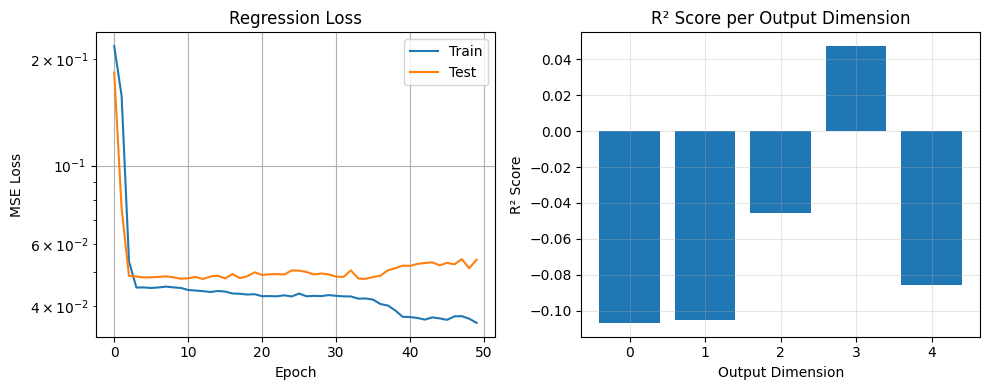

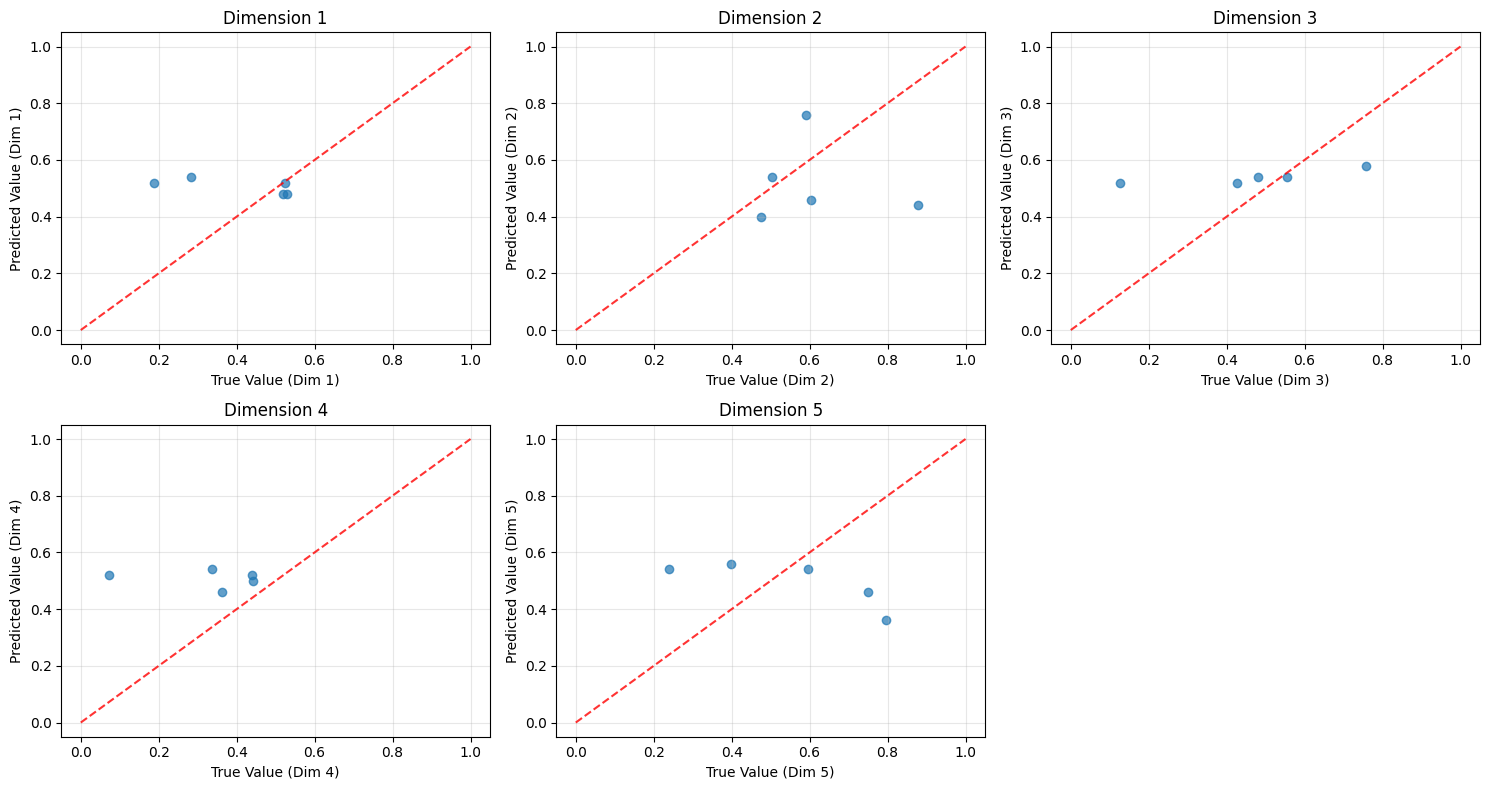

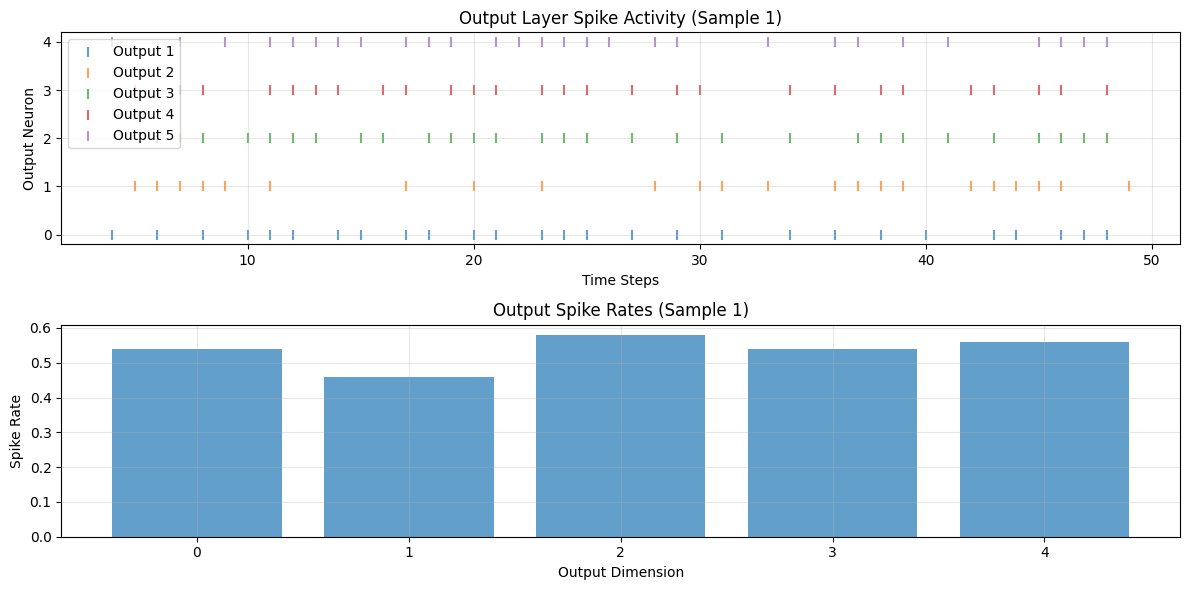

Sample Predictions vs Targets:
Sample | Predicted | Target
----------------------------------------
   1   | [0.540, 0.460, 0.580, 0.540, 0.560] | [0.282, 0.604, 0.758, 0.337, 0.398]
   2   | [0.480, 0.760, 0.520, 0.520, 0.360] | [0.530, 0.590, 0.425, 0.073, 0.795]
   3   | [0.520, 0.400, 0.540, 0.520, 0.540] | [0.187, 0.475, 0.480, 0.440, 0.596]
   4   | [0.520, 0.440, 0.540, 0.500, 0.540] | [0.523, 0.877, 0.554, 0.441, 0.240]
   5   | [0.480, 0.540, 0.520, 0.460, 0.460] | [0.519, 0.505, 0.127, 0.363, 0.751]

=== Training Complete ===
Final test MSE: 0.054161
Final mean R² score: -0.0593


In [7]:
if __name__ == "__main__":
    main()